In [1]:
import math
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as tf
import torch.linalg as la
import numpy as np
#import plotly.graph_objects as go
import pyvista as pv

#%pip list -v


In [2]:
log_level_debug = False
log_level_info = True

In [3]:
# global PyTorch settings

# disable gradient tracking not needed in this ray tracer to save compute
torch.set_grad_enabled(False)


In [4]:
# global PyVista settings

# render on client-side instead of Jupyter server
pv.set_jupyter_backend('client')

In [5]:
# check for Metal Performance Shaders in case of macOS just out of curiosity
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")


In [6]:
# check if CUDA is available
if torch.cuda.is_available():
    device_str = "cuda"
    device = torch.device(device_str)
    print(f"CUDA is available. Using first GPU.")
else:
    device_str = "cpu"
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

print(f"device={device}")


CUDA is not available. Using CPU.
device=cpu


In [7]:
# offer custom utility functions

def create_tensor(v):
      return torch.tensor(v, dtype=torch.float, requires_grad=False)

def create_tensor_on_device(v):
      return torch.tensor(v, dtype=torch.float, requires_grad=False).to(device)

def is_float_tensor(obj):
    return isinstance(obj, torch.FloatTensor) or isinstance(obj, torch.cuda.FloatTensor)

def is_float_tensor_on_device(obj):
    # obj.device.type is a str
    return is_float_tensor(obj) and (device_str == obj.device.type)

def is_long_tensor(obj):
    return isinstance(obj, torch.LongTensor) or isinstance(obj, torch.cuda.LongTensor)

def normalize_vector_custom(v):
    return v / torch.max(torch.norm(v), torch.tensor(1e-12, dtype=torch.float))

def normalize_vector(v):
    return tf.normalize(v, dim=0)

def mean_ignoring_zero(t):
    mask = t != 0.0
    t_mean = (t * mask).sum(dim=0) / mask.sum(dim=0)
    return t_mean

def see(name, value, critical=True):
    if log_level_debug or (critical and log_level_info):
        if is_float_tensor(value):
            if len(value.shape) == 0:
                # scalar
                print(f"{name}={value}")
            elif len(value.shape) == 1:
                if value.shape[0] >= 2:
                    # vector
                    print(f"torch.norm({name})={torch.norm(value)}")
                print(f"{name}.shape={value.shape}")
                print(f"{name}={value}")
            else:
               # matrix or higher-dimensional tensor
               print(f"{name}.shape={value.shape}")
               print(f"{name}=\n{value}")
        else:
            print(f"{name}={value}")

def see_more(name, value, critical=True):
    if log_level_debug or (critical and log_level_info):
        see(name, value, critical)
        if len(value.shape) > 0:
            print(f"{name}.min()={value.min()}")
            print(f"{name}.mean()={value.mean(dtype=torch.float)}")
            print(f"mean_ignoring_zero({name})={mean_ignoring_zero(value)}")
            #print(f"{name}.mode()={value.mode()}")
            print(f"{name}.median()={value.median()}")
            print(f"{name}.max()={value.max()}")


In [8]:
# define constants

minus_one_dot_zero = create_tensor_on_device(-1.0)
minus_zero_dot_five = create_tensor_on_device(-0.5)
zero_dot_zero = create_tensor_on_device(0.0)
one_dot_zero = create_tensor_on_device(1.0)
two_dot_zero = create_tensor_on_device(2.0)
four_dot_zero = create_tensor_on_device(4.0)

zero_vector_float = create_tensor_on_device([0.0, 0.0, 0.0])
zero_vector_int = torch.tensor([0.0, 0.0, 0.0], dtype=torch.int, requires_grad=False)


In [9]:
# define spheres

# each sphere is defined by its center in camera system coordinates and its radius

def create_spheres_1():
    spheres_center_py = [[-1.0, 0.0, 8.0], [2.0, -2.0, 12.0], [0.0, 0.0, 20.0], [-8.0, 0.0, 10.0]]
    spheres_center_pt = torch.tensor(spheres_center_py, dtype=torch.float, requires_grad=False)
    n_spheres = spheres_center_pt.shape[0]
    spheres_radius_py = [1.0, 5.0, 10.0, 2.0]
    spheres_radius_pt = torch.tensor(spheres_radius_py, dtype=torch.float, requires_grad=False)
    spheres_rgb_py = [[150, 90, 200], [255, 144, 0], [255, 255, 255], [255, 0, 0]]
    spheres_rgb_pt = torch.tensor(spheres_rgb_py, dtype=torch.int, requires_grad=False)
    assert spheres_center_pt.shape == (n_spheres, 3)
    assert spheres_radius_pt.shape == (n_spheres,)
    assert spheres_rgb_pt.shape == (n_spheres, 3)
    return spheres_center_pt, spheres_radius_pt, spheres_rgb_pt

spheres_center, spheres_radius, spheres_rgb = create_spheres_1()
spheres_center = spheres_center.to(device)
spheres_radius = spheres_radius.to(device)
spheres_rgb = spheres_rgb.to(device)

see("spheres_center", spheres_center)
assert is_float_tensor_on_device(spheres_center)

see("spheres_radius", spheres_radius)
assert is_float_tensor_on_device(spheres_radius)

see("spheres_rgb", spheres_rgb)

n_spheres = spheres_center.shape[0]
assert n_spheres == 4

spheres_center.shape=torch.Size([4, 3])
spheres_center=
tensor([[-1.,  0.,  8.],
        [ 2., -2., 12.],
        [ 0.,  0., 20.],
        [-8.,  0., 10.]])
torch.norm(spheres_radius)=11.401754379272461
spheres_radius.shape=torch.Size([4])
spheres_radius=tensor([ 1.,  5., 10.,  2.])
spheres_rgb=tensor([[150,  90, 200],
        [255, 144,   0],
        [255, 255, 255],
        [255,   0,   0]], dtype=torch.int32)


In [10]:
# define the camera

near = create_tensor_on_device(0.1)
far = create_tensor_on_device(100.0)

resx_float_py = 1920.0
resy_float_py = 1080.0
resx_int_py = int(resx_float_py)
resy_int_py = int(resy_float_py)
resx = create_tensor_on_device(resx_float_py)
resy = create_tensor_on_device(resy_float_py)

middle_pixel_index = int((resy_int_py / 2) * resx_int_py + (resy_int_py / 2))

n_pixels = int((resx * resy).item())
see("n_pixels", n_pixels)
assert isinstance(n_pixels, int)

resx_half = resx / two_dot_zero
resy_half = resy / two_dot_zero

see("far", far)
see("near", near)
see("resx", resx)
see("resy", resy)
see("resx_half", resx_half)
see("resy_half", resy_half)

# position of the eye point
#eye = create_tensor_on_device([0.22, 0.0, -0.44])
eye = create_tensor_on_device([0.0, 0.0, 0.0])
see("eye", eye)
see("eye.type", eye.type())
see("eye.device", eye.device)
assert is_float_tensor_on_device(eye)

# upright direction of the camera orientation
up = create_tensor_on_device([0.0, 1.0, 0.0])
up = tf.normalize(up, dim=0)
assert torch.allclose(up, normalize_vector_custom(up))
assert torch.allclose(up, normalize_vector(up))
see("up", up)
assert is_float_tensor_on_device(up)

# look is center of image plane
#look = create_tensor_on_device([1.0, 0.0, 2.0])
look = create_tensor_on_device([0.0, 0.0, 1.5])
see("look", look)
assert is_float_tensor_on_device(look)

gaze = look - eye
assert is_float_tensor_on_device(gaze)

# distance from the eye to center of image plane
distance_intrinsic = torch.norm(gaze)
see("distance_intrinsic", distance_intrinsic)
assert is_float_tensor_on_device(distance_intrinsic)

# direction from eye towards center of image plane
gaze_unit = tf.normalize(gaze, dim=0)
see("gaze", gaze)
see("gaze_unit", gaze_unit)
assert torch.isclose(torch.norm(gaze_unit), torch.tensor(1., dtype=torch.float, requires_grad=False))
assert is_float_tensor_on_device(gaze_unit)

scrnx_unit = la.cross(up, gaze_unit, dim=0)
scrnx_unit = tf.normalize(scrnx_unit, dim=0)
assert torch.isclose(torch.norm(scrnx_unit), torch.tensor(1., dtype=torch.float, requires_grad=False))
# !? hack to get numerically perfect scrnx in special case
scrnx_unit_perfect = create_tensor_on_device([1.,0.,0.])
if torch.allclose(scrnx_unit, scrnx_unit_perfect):
    print("Using perfect scrnx_unit.")
    scrnx_unit = scrnx_unit_perfect
see("scrnx_unit", scrnx_unit)
assert is_float_tensor_on_device(scrnx_unit)

scrny_unit = la.cross(gaze_unit, scrnx_unit, dim=0)
scrny_unit = tf.normalize(scrny_unit, dim=0)
assert torch.isclose(torch.norm(scrny_unit), torch.tensor(1., dtype=torch.float, requires_grad=False))
# !? hack to get numerically perfect scrny in special case
scrny_unit_perfect = create_tensor_on_device([0.,1.,0.])
if torch.allclose(scrny_unit, scrny_unit_perfect):
    print("Using perfect scrny_unit.")
    scrny_unit = scrny_unit_perfect
see("scrny_unit", scrny_unit)
assert is_float_tensor_on_device(scrny_unit)

# !? note that we compute scrnz so it points towards the eye
# i.e. it is the most reasonable normal of the image plane
scrnz_unit = la.cross(scrnx_unit, scrny_unit, dim=0)
scrnz_unit = tf.normalize(scrnz_unit, dim=0)
# !? hack to get numerically perfect scrnz in special case
scrnz_unit_perfect = create_tensor_on_device([0.,0.,1.])
if torch.allclose(scrnz_unit, scrnz_unit_perfect):
    print("Using perfect scrnz_unit.")
    scrnz_unit = scrnz_unit_perfect
see("scrnz_unit", scrnz_unit)
assert is_float_tensor_on_device(scrnz_unit)

# note that fovx is actually representing half of the horizontal field of view
fovx_degrees = create_tensor_on_device(50.0)
see("fovx_degrees", fovx_degrees)
assert is_float_tensor_on_device(fovx_degrees)

fovx_radians = torch.deg2rad(fovx_degrees)
see("fovx_radians", fovx_radians)
assert is_float_tensor_on_device(fovx_radians)

# note that fovy is actually representing half of the vertical field of view
fovy_degrees = fovx_degrees / (resx / resy)
# resx and resy are already tensors thus no neeed to wrap resx / resy
#fovy_degrees = fovx_degrees / torch.tensor(resx / resy, dtype=torch.float)
see("fovy_degrees", fovy_degrees)
assert is_float_tensor_on_device(fovy_degrees)

# override fovy to optimize magnitude of a pixel in y direction
fovy_degrees = create_tensor_on_device(33.83)
see("fovy_degrees", fovy_degrees)
assert is_float_tensor_on_device(fovy_degrees)

fovy_radians = torch.deg2rad(fovy_degrees)
see("fovy_radians", fovy_radians)
assert is_float_tensor_on_device(fovy_radians)


n_pixels=2073600
far=100.0
near=0.10000000149011612
resx=1920.0
resy=1080.0
resx_half=960.0
resy_half=540.0
torch.norm(eye)=0.0
eye.shape=torch.Size([3])
eye=tensor([0., 0., 0.])
eye.type=torch.FloatTensor
eye.device=cpu
torch.norm(up)=1.0
up.shape=torch.Size([3])
up=tensor([0., 1., 0.])
torch.norm(look)=1.5
look.shape=torch.Size([3])
look=tensor([0.0000, 0.0000, 1.5000])
distance_intrinsic=1.5
torch.norm(gaze)=1.5
gaze.shape=torch.Size([3])
gaze=tensor([0.0000, 0.0000, 1.5000])
torch.norm(gaze_unit)=1.0
gaze_unit.shape=torch.Size([3])
gaze_unit=tensor([0., 0., 1.])
Using perfect scrnx_unit.
torch.norm(scrnx_unit)=1.0
scrnx_unit.shape=torch.Size([3])
scrnx_unit=tensor([1., 0., 0.])
Using perfect scrny_unit.
torch.norm(scrny_unit)=1.0
scrny_unit.shape=torch.Size([3])
scrny_unit=tensor([0., 1., 0.])
Using perfect scrnz_unit.
torch.norm(scrnz_unit)=1.0
scrnz_unit.shape=torch.Size([3])
scrnz_unit=tensor([0., 0., 1.])
fovx_degrees=50.0
fovx_radians=0.8726646304130554
fovy_degrees=28.125
fov

In [11]:
# compute size of a pixel and scale scrnx and scrny accordingly

def compute_magnitude_of_a_pixel(distance, fov_radians, res, two_dot_zero):
     mag = torch.abs(two_dot_zero * distance * (torch.tan(fov_radians) / res))
     assert is_float_tensor_on_device(mag)
     return mag

# magx is the length aka. magnitude of a pixel in direction scrnx
magx = compute_magnitude_of_a_pixel(distance_intrinsic, fovx_radians, resx, two_dot_zero)
scrnx_scaled = scrnx_unit * magx
# scrnx is now 1 pixel long in horizontal direction of the image plane
see("scrnx_scaled", scrnx_scaled)
assert torch.isclose(torch.norm(scrnx_scaled), magx)
assert is_float_tensor_on_device(magx)
assert is_float_tensor_on_device(scrnx_scaled)

# magy is the length aka. magnitude of a pixel in direction scrny
magy = compute_magnitude_of_a_pixel(distance_intrinsic, fovy_radians, resy, two_dot_zero)
scrny_scaled = scrny_unit * magy
# scrny is now 1 pixel long in vertical direction of the image plane
see("scrny_scaled", scrny_scaled)
assert torch.isclose(torch.norm(scrny_scaled), magy)
assert is_float_tensor_on_device(magy)
assert is_float_tensor_on_device(scrny_scaled)


torch.norm(scrnx_scaled)=0.0018621149938553572
scrnx_scaled.shape=torch.Size([3])
scrnx_scaled=tensor([0.0019, 0.0000, 0.0000])
torch.norm(scrny_scaled)=0.0018616672605276108
scrny_scaled.shape=torch.Size([3])
scrny_scaled=tensor([0.0000, 0.0019, 0.0000])


In [12]:
# compute position of the pixel in the upper left corner of the image plane relative to the eye

def scale_scrn_vectors(scrnx, resx, resx_off, scrny, resy, resy_off, two_dot_zero):
    ox = scrnx * ((resx / two_dot_zero) - resx_off)
    oy = scrny * ((resy / two_dot_zero) - resy_off)
    return ox, oy

def compute_relative_position_of_pixel_upper_left(gaze, scrnx, resx, resx_off, scrny, resy, resy_off, two_dot_zero):
     # we assume that gaze is pointing exactly to the middle of the image plane
     # i.e. gaze is pointing at the center of the tiny cross
     # between the four mid-most pixels
     ox, oy = scale_scrn_vectors(scrnx, resx, resx_off, scrny, resy, resy_off, two_dot_zero)
     px_ul_pos = gaze - ox + oy
     assert is_float_tensor_on_device(px_ul_pos)
     return px_ul_pos

# we also compute these relative positions of some other pixels just for sanity checks

def compute_relative_position_of_pixel_lower_left(gaze, scrnx, resx, resx_off, scrny, resy, resy_off, two_dot_zero):
     # we assume that gaze is pointing exactly to the middle of the image plane
     # i.e. gaze is pointing at the center of the tiny cross
     # between the four mid-most pixels
     ox, oy = scale_scrn_vectors(scrnx, resx, resx_off, scrny, resy, resy_off, two_dot_zero)
     px_ll_pos = gaze - ox - oy
     assert is_float_tensor_on_device(px_ll_pos)
     return px_ll_pos

def compute_relative_position_of_pixel_upper_right(gaze, scrnx, resx, resx_off, scrny, resy, resy_off, two_dot_zero):
     # we assume that gaze is pointing exactly to the middle of the image plane
     # i.e. gaze is pointing at the center of the tiny cross
     # between the four mid-most pixels
     ox, oy = scale_scrn_vectors(scrnx, resx, resx_off, scrny, resy, resy_off, two_dot_zero)
     px_ur_pos = gaze + ox + oy
     assert is_float_tensor_on_device(px_ur_pos)
     return px_ur_pos

def compute_relative_position_of_pixel_lower_right(gaze, scrnx, resx, resx_off, scrny, resy, resy_off, two_dot_zero):
     # we assume that gaze is pointing exactly to the middle of the image plane
     # i.e. gaze is pointing at the center of the tiny cross
     # between the four mid-most pixels
     ox, oy = scale_scrn_vectors(scrnx, resx, resx_off, scrny, resy, resy_off, two_dot_zero)
     px_lr_pos = gaze + ox - oy
     assert is_float_tensor_on_device(px_lr_pos)
     return px_lr_pos

# factors to ensure computed positions are the middle of pixels
resx_off = create_tensor_on_device(0.5)
resy_off = create_tensor_on_device(0.5)
assert is_float_tensor_on_device(resx_off)
assert is_float_tensor_on_device(resy_off)

px_ul = compute_relative_position_of_pixel_upper_left(gaze, scrnx_scaled, resx, resx_off, scrny_scaled, resy, resy_off, two_dot_zero)
see("px_ul", px_ul)

px_ll = compute_relative_position_of_pixel_lower_left(gaze, scrnx_scaled, resx, resx_off, scrny_scaled, resy, resy_off, two_dot_zero)
see("px_ll", px_ll)

px_ur = compute_relative_position_of_pixel_upper_right(gaze, scrnx_scaled, resx, resx_off, scrny_scaled, resy, resy_off, two_dot_zero)
see("px_ur", px_ur)

px_lr = compute_relative_position_of_pixel_lower_right(gaze, scrnx_scaled, resx, resx_off, scrny_scaled, resy, resy_off, two_dot_zero)
see("px_lr", px_lr)

distance_px_ul_px_ur = torch.norm(px_ul - px_ur)
see("distance_px_ul_px_ur", distance_px_ul_px_ur)

# note that a pixel position vector points to the middle of a pixel
# therefore when calculating a width of the image plane
# we count two times half a pixel less
# which is represented here by subtracting resx_off twice before scaling
distance_px_ul_px_ur_anticipated = (resx - resx_off - resx_off) * magx
see("distance_px_ul_px_ur_anticipated", distance_px_ul_px_ur_anticipated, False)

assert torch.isclose(distance_px_ul_px_ur, distance_px_ul_px_ur_anticipated)

distance_px_ul_px_ll = torch.norm(px_ul - px_ll)
see("distance_px_ul_px_ll", distance_px_ul_px_ll, False)

# note that a pixel position vector points to the middle of a pixel
# therefore when calculating a height of the image plane
# we count two times half a pixel less
# which is represented here by subtracting resy_off twice before scaling
distance_px_ul_px_ll_anticipated = (resy - resy_off - resy_off) * magy
see("distance_px_ul_px_ll_anticipated", distance_px_ul_px_ll_anticipated, False)

assert torch.isclose(distance_px_ul_px_ll, distance_px_ul_px_ll_anticipated)

distance_aspect_ratio = distance_px_ul_px_ur / distance_px_ul_px_ll
see("distance_aspect_ratio", distance_aspect_ratio, False)

distance_aspect_ratio_anticipated = distance_px_ul_px_ur / distance_px_ul_px_ll
see("distance_aspect_ratio_anticipated", distance_aspect_ratio_anticipated, False)

if fovy_degrees.item() == 33.83:
    distance_aspect_ratio_anticipated_also = resx / resy
    see("distance_aspect_ratio_anticipated_also", distance_aspect_ratio_anticipated_also, False)

    assert torch.isclose(distance_aspect_ratio, distance_aspect_ratio_anticipated_also, rtol=1e-03)

    distance_aspect_ratio_anticipated_moreover = create_tensor_on_device(16.0 / 9.0)
    see("distance_aspect_ratio_anticipated_moreover", distance_aspect_ratio_anticipated_moreover, False)

    assert torch.isclose(distance_aspect_ratio, distance_aspect_ratio_anticipated_moreover, rtol=1e-03)


torch.norm(px_ul)=2.5398921966552734
px_ul.shape=torch.Size([3])
px_ul=tensor([-1.7867,  1.0044,  1.5000])
torch.norm(px_ll)=2.5398921966552734
px_ll.shape=torch.Size([3])
px_ll=tensor([-1.7867, -1.0044,  1.5000])
torch.norm(px_ur)=2.5398921966552734
px_ur.shape=torch.Size([3])
px_ur=tensor([1.7867, 1.0044, 1.5000])
torch.norm(px_lr)=2.5398921966552734
px_lr.shape=torch.Size([3])
px_lr=tensor([ 1.7867, -1.0044,  1.5000])
distance_px_ul_px_ur=3.5733985900878906


In [13]:
# compute the grid of vectors that form the image plane

# each pixel will be represented by a vector pointing to its middle

# create a vector per pixel on the image plane
# with each pixel 1.0 wide and 1.0 high
# and with the center of the image plane is the origin

img_grid_original_firstx = minus_one_dot_zero * ((resx / two_dot_zero) - resx_off)
img_grid_original_lastx = ((resx / two_dot_zero) - resx_off + one_dot_zero)
img_grid_original_firsty =((resy / two_dot_zero) - resy_off)
img_grid_original_lasty = minus_one_dot_zero * ((resy / two_dot_zero) - resy_off + one_dot_zero)

img_grid_original = torch.cartesian_prod(torch.arange(start=img_grid_original_firstx, end=img_grid_original_lastx, step=1.0, dtype=torch.float, requires_grad=False),
                                         torch.arange(start=img_grid_original_firsty, end=img_grid_original_lasty, step=-1.0, dtype=torch.float, requires_grad=False),
                                         torch.tensor([0.0], dtype=torch.float, requires_grad=False))
see("img_grid_original", img_grid_original)
img_grid_original = img_grid_original.to(device)
assert is_float_tensor_on_device(img_grid_original)

n_pixels_anticipated = img_grid_original.shape[0]
assert isinstance(n_pixels_anticipated, int)
assert n_pixels == n_pixels_anticipated

# scale the image plane using the width of a pixel and the height of a pixel

identity_matrix_3_by_3 = torch.eye(3, dtype=torch.float, requires_grad=False).to(device)
img_grid_scaling_matrix = identity_matrix_3_by_3 * create_tensor_on_device([magx, magy, 0.0])
see("img_grid_scaling_matrix", img_grid_scaling_matrix, False)
assert is_float_tensor_on_device(img_grid_scaling_matrix)

img_grid_scaled = torch.matmul(img_grid_original, img_grid_scaling_matrix)
see("img_grid_scaled", img_grid_scaled, False)
assert is_float_tensor_on_device(img_grid_scaled)

distance_px_ul_px_lr = torch.norm(px_ul - px_lr)
see("distance_px_ul_px_lr", distance_px_ul_px_lr, False)

distance_px_ul_px_lr_after_scaling = torch.norm(img_grid_scaled[n_pixels - 1] - img_grid_scaled[0])
see("distance_px_ul_px_lr_after_scaling", distance_px_ul_px_lr_after_scaling, False)

assert is_float_tensor_on_device(distance_px_ul_px_lr_after_scaling)
assert torch.isclose(distance_px_ul_px_lr, distance_px_ul_px_lr_after_scaling)

# rotate the image plane around the origin

scrnz_unit_neg = normalize_vector(minus_one_dot_zero * scrnz_unit)
assert is_float_tensor_on_device(scrnz_unit_neg)

img_grid_rotation_matrix = torch.stack([scrnx_unit, scrny_unit, scrnz_unit_neg], dim=1)
#img_grid_rotation_matrix = torch.stack([scrnx_unit, scrny_unit, scrnz_unit], dim=1)
assert is_float_tensor_on_device(img_grid_rotation_matrix)
see("img_grid_rotation_matrix", img_grid_rotation_matrix, False)

img_grid_rotated_px_ul = img_grid_rotation_matrix @ img_grid_scaled[0]
see("img_grid_rotated_px_ul", img_grid_rotated_px_ul, False)

img_grid_rotated_px_lr = img_grid_rotation_matrix @ img_grid_scaled[n_pixels - 1]
see("img_grid_rotated_px_lr", img_grid_rotated_px_lr, False)

img_grid_rotated = torch.matmul(img_grid_scaled, img_grid_rotation_matrix)
see("img_grid_rotated", img_grid_rotated, False)

distance_px_ul_px_lr_after_rotation = torch.norm(img_grid_rotated[n_pixels - 1] - img_grid_rotated[0])
see("distance_px_ul_px_lr_after_rotation", distance_px_ul_px_lr_after_rotation, False)

assert torch.isclose(distance_px_ul_px_lr_after_scaling, distance_px_ul_px_lr_after_rotation)
assert torch.isclose(distance_px_ul_px_lr, distance_px_ul_px_lr_after_rotation)

# then we translate the image plane into position

# translage by look

img_grid_translated_by_look = img_grid_rotated + look
see("img_grid_translated_by_look", img_grid_translated_by_look, False)

distance_px_ul_px_lr_after_translation_by_look = torch.norm(img_grid_translated_by_look[n_pixels - 1] - img_grid_translated_by_look[0])
see("distance_px_ul_px_lr_after_translation_by_look", distance_px_ul_px_lr_after_translation_by_look, False)

assert torch.isclose(distance_px_ul_px_lr_after_scaling, distance_px_ul_px_lr_after_translation_by_look)
assert torch.isclose(distance_px_ul_px_lr_after_scaling, distance_px_ul_px_lr_after_translation_by_look)
assert torch.isclose(distance_px_ul_px_lr, distance_px_ul_px_lr_after_translation_by_look)

# translate by eye and gaze

img_grid_translated_by_eye_and_gaze = img_grid_rotated + eye + gaze
see("img_grid_translated_by_eye_and_gaze", img_grid_translated_by_eye_and_gaze, False)

distance_px_ul_px_lr_after_translation_by_eye_and_gaze = torch.norm(img_grid_translated_by_eye_and_gaze[n_pixels - 1] - img_grid_translated_by_eye_and_gaze[0])
see("distance_px_ul_px_lr_after_translation_by_eye_and_gaze", distance_px_ul_px_lr_after_translation_by_eye_and_gaze, False)

assert torch.isclose(distance_px_ul_px_lr_after_scaling, distance_px_ul_px_lr_after_translation_by_eye_and_gaze)
assert torch.isclose(distance_px_ul_px_lr_after_scaling, distance_px_ul_px_lr_after_translation_by_eye_and_gaze)
assert torch.isclose(distance_px_ul_px_lr, distance_px_ul_px_lr_after_translation_by_eye_and_gaze)

# as expected these translations result in the same grid

assert torch.allclose(img_grid_translated_by_look, img_grid_translated_by_eye_and_gaze, rtol=0.1)

img_grid = img_grid_translated_by_look
assert is_float_tensor_on_device(img_grid)
see("img_grid", img_grid)


img_grid_original.shape=torch.Size([2073600, 3])
img_grid_original=
tensor([[-959.5000,  539.5000,    0.0000],
        [-959.5000,  538.5000,    0.0000],
        [-959.5000,  537.5000,    0.0000],
        ...,
        [ 959.5000, -537.5000,    0.0000],
        [ 959.5000, -538.5000,    0.0000],
        [ 959.5000, -539.5000,    0.0000]])
img_grid.shape=torch.Size([2073600, 3])
img_grid=
tensor([[-1.7867,  1.0044,  1.5000],
        [-1.7867,  1.0025,  1.5000],
        [-1.7867,  1.0006,  1.5000],
        ...,
        [ 1.7867, -1.0006,  1.5000],
        [ 1.7867, -1.0025,  1.5000],
        [ 1.7867, -1.0044,  1.5000]])


In [14]:
# compute a direction vector per primary ray

# since we have the image grid
# this is now just one parallelized operation

if log_level_debug:
    print(f"eye={eye}")
    print(f"look={look}")
    print(f"gaze={gaze}")
    print(f"up={up}")

    print(f"scrnx_unit={scrnx_unit}")
    print(f"scrny_unit={scrny_unit}")
    print(f"scrnz_unit={scrnz_unit}")

    print(f"scrnx_unit dot scrny_unit={torch.dot(scrnx_unit, scrny_unit)}")
    print(f"scrnx_unit dot scrnz_unit={torch.dot(scrnx_unit, scrnz_unit)}")
    print(f"scrny_unit dot scrnz_unit={torch.dot(scrny_unit, scrnz_unit)}")

    print(f"scrnx_scaled dot scrny_scaled={torch.dot(scrnx_scaled, scrny_scaled)}")
    print(f"scrnx_scaled dot scrnz_unit={torch.dot(scrnx_scaled, scrnz_unit)}")
    print(f"scrny_scaled dot scrnz_unit={torch.dot(scrny_scaled, scrnz_unit)}")

    print(f"scrnx_unit dot gaze={torch.dot(scrnx_unit, gaze)}")
    print(f"scrny_unit dot gaze={torch.dot(scrny_unit, gaze)}")

    print(f"gaze_unit dot scrnz_unit={torch.dot(gaze_unit, scrnz_unit)}")
    print(f"gaze_unit dot up={torch.dot(gaze_unit, up)}")

    print(f"gaze dot up={torch.dot(gaze, up)}")

    #print(f" dot ={torch.dot(torch.tensor([1.0, -1.0, -1.0], dtype=float, requires_grad=False), torch.tensor([1.0, 1.0, -1.0], dtype=float, requires_grad=False))}")
    #print(f" dot ={torch.dot(torch.tensor([1.0, -1.0, 1.0], dtype=float, requires_grad=False), torch.tensor([1.0, 1.0, 1.0], dtype=float, requires_grad=False))}")
    #print(f" dot ={torch.dot(torch.tensor([1.0, -1.0, 0.0], dtype=float, requires_grad=False), torch.tensor([1.0, 1.0, 0.0], dtype=float, requires_grad=False))}")
    #print(f" dot ={torch.dot(torch.tensor([1.0, -1.0, -1.0], dtype=float, requires_grad=False), torch.tensor([1.0, 1.0, 0.0], dtype=float, requires_grad=False))}")

    print(f"img_grid=\n{img_grid}")
    print(f"eye={eye}")

primary_ray_vectors = img_grid - eye
see("primary_ray_vectors", primary_ray_vectors)
assert is_float_tensor_on_device(primary_ray_vectors)

# sanity check on the edges of the image grid

primary_ray_vector_px_ul = primary_ray_vectors[0]
primary_ray_vector_px_ll = primary_ray_vectors[int(resy.item()) - 1]
primary_ray_vector_px_ur = primary_ray_vectors[primary_ray_vectors.shape[0] - int(resy.item())]
primary_ray_vector_px_lr = primary_ray_vectors[primary_ray_vectors.shape[0] - 1]

# compare vectors calculated the old and the modern way

assert torch.allclose(primary_ray_vector_px_ul, px_ul)
assert torch.allclose(primary_ray_vector_px_ul, px_ul)
assert torch.allclose(primary_ray_vector_px_ul, px_ul)
assert torch.allclose(primary_ray_vector_px_ul, px_ul)

print(f"primary_ray_vectors[middle_pixel_index]={primary_ray_vectors[middle_pixel_index]}")


primary_ray_vectors.shape=torch.Size([2073600, 3])
primary_ray_vectors=
tensor([[-1.7867,  1.0044,  1.5000],
        [-1.7867,  1.0025,  1.5000],
        [-1.7867,  1.0006,  1.5000],
        ...,
        [ 1.7867, -1.0006,  1.5000],
        [ 1.7867, -1.0025,  1.5000],
        [ 1.7867, -1.0044,  1.5000]])
primary_ray_vectors[middle_pixel_index]=tensor([ 9.3106e-04, -9.3083e-04,  1.5000e+00])


In [15]:
# normalize the primary ray vectors so that they become unit vectors

primary_ray_vectors_unit = tf.normalize(primary_ray_vectors)
see("primary_ray_vectors_unit", primary_ray_vectors_unit)
assert is_float_tensor_on_device(primary_ray_vectors_unit)

# check that for each primary ray vector the Euclidean norm sqrt(x^2 + y^2 + z^2) is 1.0
assert torch.allclose(torch.norm(primary_ray_vectors_unit, dim=1), one_dot_zero)

# it follows that for each primary ray vector the squared norm x^2 + y^2 + z^2 is also 1.0
assert torch.allclose(torch.mul(primary_ray_vectors_unit, primary_ray_vectors_unit).sum(dim=1), one_dot_zero)

# perform cross checks just to be sure

primary_ray_vector_px_ul_unit = primary_ray_vectors_unit[0]
primary_ray_vector_px_ll_unit = primary_ray_vectors_unit[int(resy.item()) - 1]
primary_ray_vector_px_ur_unit = primary_ray_vectors_unit[primary_ray_vectors.shape[0] - int(resy.item())]
primary_ray_vector_px_lr_unit = primary_ray_vectors_unit[primary_ray_vectors.shape[0] - 1]

# compare to vectors normalized individually

primary_ray_vector_px_ul_unit_alt = tf.normalize(primary_ray_vector_px_ul, dim=0)
primary_ray_vector_px_ll_unit_alt = tf.normalize(primary_ray_vector_px_ll, dim=0)
primary_ray_vector_px_ur_unit_alt = tf.normalize(primary_ray_vector_px_ur, dim=0)
primary_ray_vector_px_lr_unit_alt = tf.normalize(primary_ray_vector_px_lr, dim=0)

assert torch.allclose(primary_ray_vector_px_ul_unit, primary_ray_vector_px_ul_unit_alt)
assert torch.allclose(primary_ray_vector_px_ll_unit, primary_ray_vector_px_ll_unit_alt)
assert torch.allclose(primary_ray_vector_px_ur_unit, primary_ray_vector_px_ur_unit_alt)
assert torch.allclose(primary_ray_vector_px_lr_unit, primary_ray_vector_px_lr_unit_alt)

# compare to vectors calculated the old way

px_ul_unit = tf.normalize(px_ul, dim=0)
px_ll_unit = tf.normalize(px_ll, dim=0)
px_ur_unit = tf.normalize(px_ur, dim=0)
px_lr_unit = tf.normalize(px_lr, dim=0)

assert torch.allclose(primary_ray_vector_px_ul_unit, px_ul_unit)
assert torch.allclose(primary_ray_vector_px_ll_unit, px_ll_unit)
assert torch.allclose(primary_ray_vector_px_ur_unit, px_ur_unit)
assert torch.allclose(primary_ray_vector_px_lr_unit, px_lr_unit)

print(f"primary_ray_vectors_unit[middle_pixel_index]={primary_ray_vectors_unit[middle_pixel_index]}")


primary_ray_vectors_unit.shape=torch.Size([2073600, 3])
primary_ray_vectors_unit=
tensor([[-0.7035,  0.3954,  0.5906],
        [-0.7037,  0.3948,  0.5907],
        [-0.7039,  0.3942,  0.5909],
        ...,
        [ 0.7039, -0.3942,  0.5909],
        [ 0.7037, -0.3948,  0.5907],
        [ 0.7035, -0.3954,  0.5906]])
primary_ray_vectors_unit[middle_pixel_index]=tensor([ 6.2070e-04, -6.2056e-04,  1.0000e+00])


In [16]:
# define function to compute intersections of rays with spheres

def intersect_rays_with_spheres(n_rays, n_spheres, ray_origin_per_sphere, spheres_center, spheres_radius):
    # n_rays is the number of rays
    
    # n_spheres is the number of spheres

    # ray_origin_per_sphere contains one row per sphere where each row is the 3D vector of the origin of the ray
    # when shooting rays from the camera this is an n by 3 tensor where each row is the eye vector
    assert ray_origin_per_sphere.shape == (n_spheres, 3)
        
    # spheres_center contains one row per sphere where each row is the 3D vector if the center of the sphere
    assert spheres_center.shape == (n_spheres, 3)
    
    # spheres_radius contains one scalar per sphere where each scalar is the radius of the sphere in radians
    assert spheres_radius.shape == (n_spheres, )

    # notation somewhat aligned with the lecture script
    # E = P = eye = where all primary rays start
    # D = primary ray = direction from eye to pixel represented as unit vector
    # S = center of a sphere
    # r = radius of a sphere
    # t = distance from eye to intersection point
    # R = E + t * D = vector of intersection point
    
    # compute the coefficient A of the quadratic equation
    # A = x_D^2 + y_D^2 + z_D^2 = dot(D, D)
    # which is just the dot product of D with itself
    # which is 1.0 since the ray direction vectors are unit vectors
    a = one_dot_zero    
    
    # compute the coefficient b of the quadratic equation
    # B = 2 * (x_D(x_E - x_S) + y_D(y_E - y_S) + z_D(z_E - z_S)) = 2 * dot(D, E - S)
    # compute E - C for all rays with one element-wise matrix subtraction
    ray_origin_minus_spheres_center = ray_origin_per_sphere - spheres_center
    see("ray_origin_minus_spheres_center", ray_origin_minus_spheres_center, False)
    assert is_float_tensor_on_device(ray_origin_minus_spheres_center)
    assert ray_origin_minus_spheres_center.shape == (n_spheres, 3)
    # we actually compute all dot products with just one matrix multiplication
    b = two_dot_zero * torch.matmul(primary_ray_vectors_unit, ray_origin_minus_spheres_center.T)
    see("b", b)
    assert is_float_tensor_on_device(b)
    assert b.shape == (n_rays, n_spheres)
    
    # compute the coefficient c of the quadratic equation
    # C = (x_E - x_S)^2 + (y_E - y_S)^2 + (z_E - z_S)^2 = dot(E - S, E - S)

    # compute the square of each radius
    spheres_radius_sqaured = torch.square(spheres_radius)
    see("spheres_radius_sqaured", spheres_radius_sqaured, False)
    assert is_float_tensor_on_device(spheres_radius_sqaured)
    assert spheres_radius_sqaured.shape == (n_spheres,)
    # we compute all the dot products and all the scalar subtractions in one go
    c = torch.sum(torch.mul(ray_origin_minus_spheres_center, ray_origin_minus_spheres_center), dim=1) - spheres_radius_sqaured
    see("c", c)
    assert is_float_tensor_on_device(c)
    assert c.shape == (n_spheres,)  
    
    # compute the discriminant of the quadratic equation
    # discriminant = B^2 - 4 * C
    four_dot_zero_times_c_stacked = (four_dot_zero * c).unsqueeze(0).repeat(n_rays, 1)
    see("four_dot_zero_times_c_stacked", four_dot_zero_times_c_stacked, False)
    assert is_float_tensor_on_device(four_dot_zero_times_c_stacked)
    assert four_dot_zero_times_c_stacked.shape == (n_rays, n_spheres)
    discriminants = torch.square(b) - four_dot_zero_times_c_stacked
    see("discriminants", discriminants, False)
    assert is_float_tensor_on_device(discriminants)
    assert discriminants.shape == (n_rays, n_spheres)    

    # mask discriminants regarding number of intersections between any ray and sphere
    spheres_2_solution_indices = discriminants > 1e-8
    see("spheres_2_solution_indices", spheres_2_solution_indices, False)
    assert spheres_2_solution_indices.shape == (n_rays, n_spheres)
    spheres_1_solution_indices = (discriminants > -1e-8) & (discriminants < 1e-8)
    see("spheres_1_solution_indices", spheres_1_solution_indices, False)
    assert spheres_1_solution_indices.shape == (n_rays, n_spheres)
    spheres_0_solution_indices = (discriminants < 1e-8)
    see("spheres_0_solution_indices", spheres_0_solution_indices, False)
    assert spheres_0_solution_indices.shape == (n_rays, n_spheres)
    
    # count for how many pairs of rays spheres there are 2, 1, 0 solutions
    n_2_solutions = torch.count_nonzero(spheres_2_solution_indices)
    see("n_2_solutions", n_2_solutions)
    n_1_solutions = torch.count_nonzero(spheres_1_solution_indices)
    see("n_1_solutions", n_1_solutions)
    n_0_solutions = torch.count_nonzero(spheres_0_solution_indices)
    see("n_0_solutions", n_0_solutions)
    
    # compute the square root of the discriminant of the quadratic equation
    # sqrt(discriminant) = sqrt(B^2 - 4 * C)
    # note that there are two solutions to the square root if discriminant is > 0
    # we accomodate for that by using + and - sign in subsequent formula
    discriminants_sqrt = discriminants.clone()
    discriminants_sqrt[spheres_2_solution_indices] = torch.sqrt(discriminants[spheres_2_solution_indices])
    discriminants_sqrt[spheres_1_solution_indices] = 0.0
    discriminants_sqrt[spheres_0_solution_indices] = -1.0
    see("discriminants_sqrt", discriminants_sqrt, False)
    assert is_float_tensor_on_device(discriminants_sqrt)
    assert discriminants_sqrt.shape == (n_rays, n_spheres)
    
    # compute the distances from the eye to the intersections
    # t_0 = (- B - sqrt(B^2 - 4 * C)) / 2 = -0.5 * (B + sqrt(B^2 - 4 * C))
    # t_1 = (- B + sqrt(B^2 - 4 * C)) / 2 = -0.5 * (B - sqrt(B^2 - 4 * C))
    t_0s = minus_zero_dot_five * (b + discriminants_sqrt)
    t_0s[spheres_0_solution_indices] = 0.0
    see_more("t_0s", t_0s, False)
    assert is_float_tensor_on_device(t_0s)
    assert t_0s.shape == (n_rays, n_spheres)
    t_1s = minus_zero_dot_five * (b - discriminants_sqrt)
    t_1s[spheres_0_solution_indices] = 0.0
    see_more("t_0s", t_0s, False)
    see_more("t_1s", t_1s, False)
    assert is_float_tensor_on_device(t_1s)
    assert t_1s.shape == (n_rays, n_spheres)
    
    # note that in case a sphere would be completely or partially behind the camera
    # we would need to cull away all intersections behind the camera
    # by setting them to far or infinity before taking the minimum
    
    # note that the 1 solution case is rare
    # and corresponding values in t_0s and t_1s equal
    # in that case the minimum function will simply use that value
    
    ts = torch.minimum(t_0s, t_1s)
    ts[spheres_0_solution_indices] = 0.0
    see_more("ts", ts, False)
    assert is_float_tensor_on_device(ts)
    assert ts.shape == (n_rays, n_spheres)
    
    # determine the minimum t for each ray
    #ts[spheres_0_solution_indices] = far + 10.0
    ts[spheres_0_solution_indices] = far + 10.0
    ts_minimum = torch.min(ts, dim=1)
    ts_min = ts_minimum.values
    ts_background_mask = ts_min > far
    assert ts_background_mask.shape == (n_rays,)
    ts_foreground_mask = ts_min <= far
    assert ts_foreground_mask.shape == (n_rays,)
    ts_foreground_mask_with_0 = ts_foreground_mask.clone()
    ts_foreground_mask_with_0[0] = True
    ts_min[ts_background_mask] = 0.0
    see_more("ts_min", ts_min)
    assert is_float_tensor_on_device(ts_min)
    assert ts_min.shape == (n_rays,)
    
    # compute intersection points
    # by scaling each primary ray unit vector by the corresponding minimum t
    points_hit = torch.mul(primary_ray_vectors_unit, torch.unsqueeze(ts_min, dim=1))
    points_hit[ts_background_mask] = zero_vector_float
    see_more("points_hit", points_hit)
    assert points_hit.shape == (n_pixels, 3)    
    
    # for each ray note the index of the sphere that the ray hit
    #ts_min_spheres_index = torch.remainder(ts_minimum.indices, n_spheres)
    spheres_index_hit = torch.remainder(ts_minimum.indices, n_spheres)
    see_more("ts_min_spheres_index", spheres_index_hit)
    assert is_long_tensor(spheres_index_hit)
    assert ts_min.shape == (n_rays,)
    
     # for each ray get the center of the sphere that the ray hit
    spheres_center_hit = spheres_center[spheres_index_hit]
    see("spheres_center_hit", spheres_center_hit)
    assert is_float_tensor_on_device(spheres_center_hit)
    assert spheres_center_hit.shape == (n_rays, 3)
    
    # also compute surface normal at each intersection in terms of a unit vector
    surface_normals_hit = points_hit - spheres_center_hit
    surface_normals_hit[ts_background_mask] = zero_vector_float
    surface_normals_hit_unit = tf.normalize(surface_normals_hit)
    see_more("surface_normals_hit_unit", surface_normals_hit_unit)
    assert is_float_tensor_on_device(surface_normals_hit_unit)
    
    # sanity check
    surface_normals_hit_unit_norm = torch.norm(surface_normals_hit_unit, p=2, dim=1, keepdim=True)
    see_more("surface_normals_unit_norm", surface_normals_hit_unit_norm, False)
    assert is_float_tensor_on_device(surface_normals_hit_unit_norm)
    assert torch.allclose(surface_normals_hit_unit_norm[ts_foreground_mask], one_dot_zero)
    assert torch.allclose(surface_normals_hit_unit_norm[ts_background_mask], zero_vector_float)    
    
    background_mask = ts_background_mask
    foreground_mask = ts_foreground_mask
    foreground_mask_with_0 = ts_foreground_mask_with_0
    
    return points_hit, surface_normals_hit, surface_normals_hit_unit, spheres_index_hit, spheres_center_hit, background_mask, foreground_mask, foreground_mask_with_0


In [17]:
# compute intersections of primary rays with spheres

# make a tensor that contains one copy of eye per sphere
eyes_spheres_center = eye.unsqueeze(0).repeat(n_spheres, 1)
see("eyes_spheres_center", eyes_spheres_center, False)
assert is_float_tensor_on_device(eyes_spheres_center)
assert eyes_spheres_center.shape == (n_spheres, 3)

# make a tensor that contains one copy of eye per primary ray
eyes_pixels = eye.unsqueeze(0).repeat(n_pixels, 1)
assert is_float_tensor_on_device(eyes_pixels)
assert eyes_pixels.shape == (n_pixels, 3)
see("eyes_pixels", eyes_pixels, False)

points_hit, surface_normals_hit, surface_normals_hit_unit, spheres_index_hit, spheres_center_hit, background_mask, foreground_mask, foreground_mask_with_0 = intersect_rays_with_spheres(n_pixels, n_spheres, eyes_spheres_center, spheres_center, spheres_radius)

print(f"spheres_index_hit[middle_pixel_index]={spheres_index_hit[middle_pixel_index]}")

print(f"spheres_center_hit[middle_pixel_index]={spheres_center_hit[middle_pixel_index]}")

print(f"points_hit[middle_pixel_index]={points_hit[middle_pixel_index]}")

print(f"surface_normals_hit[middle_pixel_index]={surface_normals_hit[middle_pixel_index]}")

print(f"surface_normals_hit_unit[middle_pixel_index]={surface_normals_hit_unit[middle_pixel_index]}")


b.shape=torch.Size([2073600, 4])
b=
tensor([[-10.8561,  -9.7783, -23.6230, -23.0668],
        [-10.8593,  -9.7840, -23.6299, -23.0735],
        [-10.8624,  -9.7898, -23.6367, -23.0802],
        ...,
        [ -8.0470, -18.5743, -23.6367,  -0.5566],
        [ -8.0446, -18.5718, -23.6299,  -0.5564],
        [ -8.0423, -18.5694, -23.6230,  -0.5562]])
torch.norm(c)=368.54443359375
c.shape=torch.Size([4])
c=tensor([ 64., 127., 300., 160.])
n_2_solutions=1264526
n_1_solutions=4
n_0_solutions=7029874
torch.norm(ts_min)=10057.7109375
ts_min.shape=torch.Size([2073600])
ts_min=tensor([0., 0., 0.,  ..., 0., 0., 0.])
ts_min.min()=0.0
ts_min.mean()=4.429181098937988
mean_ignoring_zero(ts_min)=10.468738555908203
ts_min.median()=0.0
ts_min.max()=17.314985275268555
points_hit.shape=torch.Size([2073600, 3])
points_hit=
tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])
points_hit.min()=-9.33489990234375
point

In [18]:
spheres_rgb_hit = spheres_rgb[spheres_index_hit]
see("spheres_rgb_hit", spheres_rgb_hit)
assert spheres_rgb_hit.shape == (n_pixels, 3)


spheres_rgb_hit=tensor([[150,  90, 200],
        [150,  90, 200],
        [150,  90, 200],
        ...,
        [150,  90, 200],
        [150,  90, 200],
        [150,  90, 200]], dtype=torch.int32)


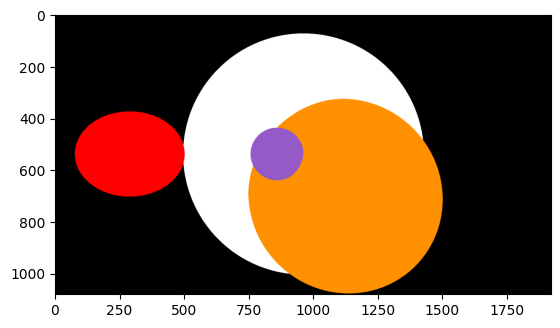

In [19]:
img_rgb = spheres_rgb_hit.clone()
img_rgb[background_mask] = zero_vector_int
img_rgb_view = img_rgb.view(resx_int_py, resy_int_py, 3)
img_rgb_view_permuted = img_rgb_view.permute(1, 0, 2)
assert img_rgb_view_permuted.shape == (resy_int_py, resx_int_py, 3)
plt.imshow(img_rgb_view_permuted)

In [21]:

def plot_vectors_with_z_value_as_color(vectors, foreground_mask, clim, cmap):
    pcd_pv = pv.PolyData(vectors[foreground_mask].numpy())
    pcd_pv['point_color'] = pcd_pv.points[:, 2] # use z values as color
    plotter = pv.Plotter()
    plotter.add_mesh(pcd_pv,
            scalars='point_color',
            clim=clim,
            cmap=cmap)
    return plotter

plotter = plot_vectors_with_z_value_as_color(points_hit, foreground_mask_with_0, clim=[6,16], cmap='terrain')
plotter.show()


Widget(value='<iframe src="http://localhost:58248/index.html?ui=P_0x12c968620_0&reconnect=auto" class="pyvista…

In [22]:
def plot_vectors_with_magnitude_as_color(vectors, foreground_mask, clim, cmap):
    pcd_pv = pv.PolyData(vectors[foreground_mask].numpy())
    pcd_pv['point_color'] = torch.norm(vectors[foreground_mask], p=2, dim=1, keepdim=True).numpy()
    plotter = pv.Plotter()
    plotter.add_mesh(pcd_pv,
        scalars='point_color',
        clim=clim,
        cmap=cmap)
    return plotter

plotter = plot_vectors_with_magnitude_as_color(surface_normals_hit, foreground_mask_with_0, clim=[0,12], cmap='terrain')
plotter.show()


Widget(value='<iframe src="http://localhost:58248/index.html?ui=P_0x12f5dce30_1&reconnect=auto" class="pyvista…